In [1]:
import pandas as pd
import numpy as np
from kss import split_sentences
from pykospacing import Spacing
from hanspell import spell_checker
from konlpy.tag import Okt, Kkma, Hannanum, Komoran, Mecab
import re
from textrankr import TextRank
from typing import List
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from konlpy.tag import Okt, Komoran
from soylemma import Lemmatizer   # !pip install soylemma

# 동사, 형용사별로 입력 받을 시 용언의 원형으로 리턴
def Lemmatizer_NA(string):
    
    if len(string)!=1: # 1글자는 제외하기 (판단 결과)
        lemmatizer = Lemmatizer(dictionary_name='default')   
        list_st=lemmatizer.lemmatize(string)                       # 1번째 원형 복귀 방법
        
        if len(list_st)==1: #lemmatizer로 바로 인식 하면 리턴
            return str(list_st[0][0])
            
        else:
            komoran=Komoran()
            morphtags = komoran.pos(string) 
            if morphtags[0][1] == 'VA' or morphtags[0][1] == 'VV':  # 2번째 원형 복귀 방법
                return morphtags[0][0] + '다'  # 1번째 방법 틀릴 경우 VA+VV 작업을 거친다. 

            else:
                temp=''
                check=0
                for i in range(1,len(morphtags)):                   
                    if len(morphtags)==1:  # 하나로 나뉘는 것은 의미 없음.
                        break

                    if morphtags[i-1][1]=='XR' and morphtags[i][1]=='XSA': # 3번째 원형 복귀 방법
                        temp=str(morphtags[i-1][0])+str(morphtags[i][0])
                        break

                    if morphtags[i-1][1]=='NNG' and morphtags[i][1]=='NNG':   # 4번째 원형 복귀 방법 
                        temp=temp+str(morphtags[i-1][0])+str(morphtags[i][0])
                        check+=1
                    elif morphtags[i-1][1]=='NNG' and morphtags[i][1]=='XSV': # 4번째 원형 복귀 방법 (이어서)
                        temp2=''
                        for k in range(check):
                            temp2+=morphtags[k][0]
                        temp=temp2+str(morphtags[i-1][0])+str(morphtags[i][0])
                        break

                    if morphtags[i-1][1]=='NNG' and morphtags[i][1]=='XSA':    # 5번째 원형 복귀 방법
                        temp=string[:i-1]+str(morphtags[i-1][0])+str(morphtags[i][0])
                        break

                    if morphtags[i-1][1]=='VX':                            # 6번째 원형 복귀 방법
                        for k in range(i):
                            temp+=morphtags[k][0]
                        break

                    if morphtags[i-1][1]=='MAG' and morphtags[i][1]=='VV':     # 7번째 원형 복귀 방법
                        temp=string[:i-1]+str(morphtags[i-1][0])+str(morphtags[i][0])
                        break

                    if morphtags[i-1][1]=='MAG' and morphtags[i][1]=='XSV':    # 8번째 원형 복귀 방법
                        temp=string[:i-1]+str(morphtags[i-1][0])+str(morphtags[i][0])
                        break

                    if morphtags[i-1][1]=='NNG' and morphtags[i][1]=='VV':     # 9번째 원형 복귀 방법
                        temp=string[:i-1]+str(morphtags[i-1][0])+str(morphtags[i][0])
                        break

                if len(temp)!=0:
                    temp+='다'
                    return temp
                
                else:
                    return str(string)   # 이래도 안될 경우.. 그대로 return
    
    else:
        return str(string)

In [3]:
data=pd.read_csv("dataset/Q&A_rank.csv",encoding='utf-8-sig')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45010 entries, 0 to 45009
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       44327 non-null  object
 1   A       44474 non-null  object
dtypes: object(2)
memory usage: 703.4+ KB


In [5]:
data=data.dropna(subset=['Q','A']).reset_index(drop=True)

In [6]:
col='Q'
for i in range(len(data[col])):
    data.loc[i,col+'_len']=int(len(data.loc[i,col]))

In [7]:
col='A'
for i in range(len(data[col])):
    data.loc[i,col+'_len']=int(len(data.loc[i,col]))

In [8]:
sentence_len_df=data.iloc[:,2:]

<BarContainer object of 264 artists>

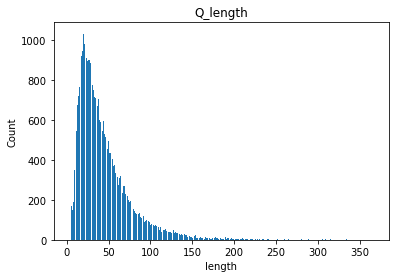

In [9]:
# Q 문장 길이 측정
x=set(sentence_len_df['Q_len'])
plot_dic_q={}
for key in x:
    plot_dic_q[key]=0
for num in sentence_len_df['Q_len']:
    plot_dic_q[num]+=1


plt.title('Q_length')
plt.xlabel('length')
plt.ylabel('Count')
plt.bar(plot_dic_q.keys(),plot_dic_q.values())

<BarContainer object of 259 artists>

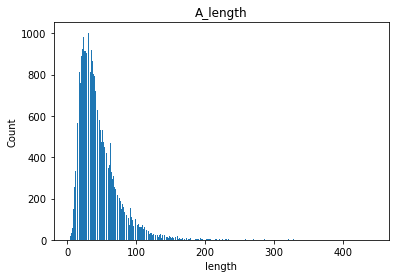

In [10]:
# A 문장 길이 측정
x=set(sentence_len_df['A_len'])
plot_dic_a={}
for key in x:
    plot_dic_a[key]=0
for num in sentence_len_df['A_len']:
    plot_dic_a[num]+=1


plt.title('A_length')
plt.xlabel('length')
plt.ylabel('Count')
plt.bar(plot_dic_a.keys(),plot_dic_a.values())

In [11]:
# Q 상위 3% 제거
ranked_q=sorted(plot_dic_q.items(),key=(lambda x:x[0]), reverse=True)
total=0
for num, cnt in ranked_q:
    total+=cnt
threshold_q=total*0.03
i=0
j=0
while i<threshold_q:
    i+=ranked_q[j][1]
    j+=1
    key=ranked_q[j][0]
print(f"Q sentence Threshold: {key}")             

Q sentence Threshold: 123.0


In [12]:
temp=[]
for i in range(len(data)):
    if data.loc[i,'Q_len']>123:
        temp.append(i)
        
data=data.drop(temp,axis=0)        
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42458 entries, 0 to 42457
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Q       42458 non-null  object 
 1   A       42458 non-null  object 
 2   Q_len   42458 non-null  float64
 3   A_len   42458 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.3+ MB


In [13]:
# A 상위 3% 제거
ranked_a=sorted(plot_dic_a.items(),key=(lambda x:x[0]), reverse=True)
total=0
for num, cnt in ranked_a:
    total+=cnt
threshold_a=total*0.03
i=0
j=0
while i<threshold_a:
    i+=ranked_a[j][1]
    j+=1
    key=ranked_a[j][0]
print(f"A sentence Threshold: {key}")             

A sentence Threshold: 112.0


In [14]:
temp=[]
for i in range(len(data)):
    if data.loc[i,'A_len']>112:
        temp.append(i)
        
data=data.drop(temp,axis=0)        
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41149 entries, 0 to 41148
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Q       41149 non-null  object 
 1   A       41149 non-null  object 
 2   Q_len   41149 non-null  float64
 3   A_len   41149 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.3+ MB


In [15]:
data=data.iloc[:,:2]

In [16]:
data.to_csv("dataset/Q&A_com.csv", encoding='utf-8-sig', index=False)

### Model Start 

In [3]:
data=pd.read_csv("dataset/Q&A_com.csv",encoding='utf-8-sig')
voca=pd.read_csv("model/voca_dictionary.csv",encoding='utf-8-sig')

In [4]:
okt=Okt()
komoran=Komoran()

In [5]:
#형태소 전처리 (용언 원형 복원 및 사전 검토)
def process_morph(sentence, dictionary=True):
    temp=[]
    for st, ty in okt.pos(sentence, stem=True, norm=True):
        if ty=='Verb' or ty=='Adjective':    # 용언 원형으로 변형
            st=Lemmatizer_NA(st)
        temp.append(st)
        
    if dictionary:   # 새로운 문장 받았을 경우
        sentence=''.join(temp)
        spacing=Spacing(rules=voca.index)
        sentence=spacing(sentence)
        temp=[]
        for st, ty in komoran.pos(sentence):
            if ty[0]=='N':
                for key in voca.index:
                    if st in voca.loc[key,'values'].split():
                        st=key  # key로 변경하기
                        break
            temp.append(st)
        sentence=' '.join(temp)
        return sentence
    else:
        sentence=' '.join(temp)
        return sentence

In [6]:
# START 토큰은 형태소 변환 후 decoder input에 END 토큰은 decoder output에 추가합니다.
def sentence_add(sentence, is_question=True, morph=True):
    if morph:
        sentence = ' '.join(okt.morphs(sentence))
    else:
        sentence = process_morph(sentence, False)
        
    if is_question:
        return sentence
    else:
        return ('<START> ' + sentence, sentence + ' <END>')

In [7]:
# list로 데이터 질의, 답변 전처리
def preprocess(df, Q, A):
    questions = []
    answer_in = []
    answer_out = []

    for i in tqdm(range(len(df[Q]))):
        
        question = sentence_add(df.loc[i,Q], is_question=True, morph=False)
        questions.append(question)
        
        in_, out_ = sentence_add(df.loc[i,A], is_question=False, morph=True)
        answer_in.append(in_)
        answer_out.append(out_)
        if (i+1)%50==0:
            np.save('model/questions1.npy', questions)
            np.save('model/answer_in1.npy', answer_in)
            np.save('model/answer_out1.npy', answer_out)
    return questions, answer_in, answer_out

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41149 entries, 0 to 41148
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       41149 non-null  object
 1   A       41149 non-null  object
dtypes: object(2)
memory usage: 643.1+ KB


In [9]:
data.head()

,Q,A
0,분리 불안장애 심한 강아지 종류는 뭔가요 분리 불안장애 강아지 종류는 다 분리 불안...,우선 번에 대해서 말씀드리자면 불안장애 강아지 종류가 아니라 강아지 한 마리 한 마...
1,진도 강아지 세 살 제가 외출 하울링 해서 불안장애 훈련 중인데 집 훈련이랑 잠자리...,그리고 강아지 자기 자리라고 생각하는 자리에 앉아서 쉬고 있을 때는 쓰다듬으면 안 되나요
2,그래서 강아지 한 마리 데려오려고 했는데 괜찮을까요,이사하고 스트레스 보이는 강아지 지금 그 아이도 적응해야 하는데 좋아지지 않겠냐고 ...
3,불안장애 강아지 강아지 노즈 워크 워크 추천해주세요,노즈 워크 워크가 좋기는 한데 식탐이 없는 아이들 귀찮아하는 경우가 있어요
4,물론 다른 가족들은 다 자고 있고 엄마 야간근무라서 안 계시고요 불안장애 증상이라는...,강아지 강아지 등이 많이 보이는 불안장애 증세일 수 있는데 보호자 외출 것을 알기 ...


In [10]:
# dataframe을 전처리 한 후 리스트로 전환
temp_df=data.iloc[15000:20566,:].reset_index(drop=True)
questions, answer_in, answer_out = preprocess(temp_df, 'Q', 'A')

100%|████████████████████████████████████████████████████████████████████████████| 5566/5566 [4:55:07<00:00,  3.18s/it]


In [8]:
# 리스트 합치기
questions=[]
answer_in=[]
answer_out=[]
list_=[['questions_ms_1','questions_ms_2','questions','questions1','questions_hj','questions_hj_1','questions_my','questions_my1'],
       ['answer_in_ms_1','answer_in_ms_2','answer_in','answer_in1','answer_in_hj','answer_in_hj_1','answer_in_my','answer_in_my1'],
       ['answer_out_ms_1','answer_out_ms_2','answer_out','answer_out1','answer_out_hj','answer_out_hj_1','answer_out_my','answer_out_my1']]

i=0
for lst in list_:
    for name in lst:
        if i==0:
            question=np.load('model/'+str(name)+'.npy', allow_pickle=True)
            if len(questions)==0:
                questions=list(question)
            else:
                questions+=list(question)
        elif i==1:
            answerin=np.load('model/'+str(name)+'.npy', allow_pickle=True)
            if len(answerin)==0:
                answer_in=list(answerin)
            else:
                answer_in.extend(list(answerin))
        else:
            answerout=np.load('model/'+str(name)+'.npy', allow_pickle=True)
            if len(answerout)==0:
                answer_out=list(answerout)
            else:
                answer_out.extend(list(answerout))
    i+=1

In [9]:
len(answer_out)

41062

In [10]:
len(questions)

41062

In [11]:
answer_in[:10]

['<START> 우선 번 에 대해 서 말씀드리자면 불안장애 강아지 종류 가 아니라 강아지 한 마리 한 마리 에 따라 달라 서 특별히 불안장애 심한 강아지 종류 가 있다고 꼬집어서 말 하기는 조금 그렇네요',
 '<START> 그리고 강아지 자기 자리 라고 생각 하는 자리 에 앉아서 쉬 고 있을 때 는 쓰다듬으면 안 되나요',
 '<START> 이사 하고 스트레스 보이는 강아지 지금 그 아이 도 적응해야 하는데 좋아지지 않겠냐고 하시겠지만 확률 로 따지면 좋아질 확률 나빠질 확률 입니다',
 '<START> 노 즈 워 크 워 크가 좋 기는 한데 식탐 이 없는 아이 들 귀찮아하는 경우 가 있어요',
 '<START> 강아지 강아지 등 이 많이 보이는 불안장애 증세 일 수 있는데 보호자 외출 것 을 알기 때문 에 불안장애 느끼는 것 입니다',
 '<START> 낑낑 거리 거나 주인 이 움직일 때 마다 불안장애 주인 이 외출 나서 집 에 오면 집 이 어질러 있거나 그럴 수도 있습니다',
 '<START> 강아지 분리 불안 증 같으니 인터넷 교육 방법 쳐 보세요',
 '<START> 제 가 겪어 봤지만 불안장애 심하면 강아지 보호자 년 일 붙어있어도 부족한 그런 감정 이 거든요',
 '<START> 한숨 을 쉬 면 강아지 불안장애 덜 수 있다고 하네요',
 '<START> 강아지 불안장애 고민 많으시겠어요']

In [12]:
answer_out[:10]

['우선 번 에 대해 서 말씀드리자면 불안장애 강아지 종류 가 아니라 강아지 한 마리 한 마리 에 따라 달라 서 특별히 불안장애 심한 강아지 종류 가 있다고 꼬집어서 말 하기는 조금 그렇네요 <END>',
 '그리고 강아지 자기 자리 라고 생각 하는 자리 에 앉아서 쉬 고 있을 때 는 쓰다듬으면 안 되나요 <END>',
 '이사 하고 스트레스 보이는 강아지 지금 그 아이 도 적응해야 하는데 좋아지지 않겠냐고 하시겠지만 확률 로 따지면 좋아질 확률 나빠질 확률 입니다 <END>',
 '노 즈 워 크 워 크가 좋 기는 한데 식탐 이 없는 아이 들 귀찮아하는 경우 가 있어요 <END>',
 '강아지 강아지 등 이 많이 보이는 불안장애 증세 일 수 있는데 보호자 외출 것 을 알기 때문 에 불안장애 느끼는 것 입니다 <END>',
 '낑낑 거리 거나 주인 이 움직일 때 마다 불안장애 주인 이 외출 나서 집 에 오면 집 이 어질러 있거나 그럴 수도 있습니다 <END>',
 '강아지 분리 불안 증 같으니 인터넷 교육 방법 쳐 보세요 <END>',
 '제 가 겪어 봤지만 불안장애 심하면 강아지 보호자 년 일 붙어있어도 부족한 그런 감정 이 거든요 <END>',
 '한숨 을 쉬 면 강아지 불안장애 덜 수 있다고 하네요 <END>',
 '강아지 불안장애 고민 많으시겠어요 <END>']

In [13]:
all_sentences = questions + answer_in + answer_out

In [14]:
# 총 data 개수
a = (' '.join(questions) + ' '.join(answer_out)).split()
len(set(a))

40850

In [15]:
np.save('model/questions_g.npy', questions)
np.save('model/answer_in_g.npy', answer_in)
np.save('model/answer_out_g.npy', answer_out)

### Word_index_Voca 제작하기
 1. keras tokenizer로 Word_index 제작 
 2. 원형 형태로 정제를 했기 때문에 Q 값은 원형 상태로 들어가게 됨
 3. 패딩을 통해 길이 또한 맞추기

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
# Word_Index_Voca 작성
tokenizer = Tokenizer(filters='', lower=False, oov_token='<OOV>')

In [18]:
tokenizer.fit_on_texts(all_sentences)

In [19]:
# word2index 호출
for word, idx in tokenizer.word_index.items():
    print(f'{word}\t >>> \t{idx}')
    if idx > 10:
        break

<OOV>	 >>> 	1
강아지	 >>> 	2
이	 >>> 	3
을	 >>> 	4
<START>	 >>> 	5
<END>	 >>> 	6
에	 >>> 	7
가	 >>> 	8
하다	 >>> 	9
를	 >>> 	10
것	 >>> 	11


In [20]:
# 토크나이저 워드 길이
len(tokenizer.word_index)

40851

In [21]:
np.save('model/all_tokenizer.npy', tokenizer)

In [22]:
question_sequence = tokenizer.texts_to_sequences(questions)
answer_in_sequence = tokenizer.texts_to_sequences(answer_in)
answer_out_sequence = tokenizer.texts_to_sequences(answer_out)

In [23]:
question_padded = pad_sequences(question_sequence, truncating='post', padding='post')
answer_in_padded = pad_sequences(answer_in_sequence, truncating='post', padding='post')
answer_out_padded = pad_sequences(answer_out_sequence, truncating='post', padding='post')

In [24]:
question_padded.shape

(41062, 58)

In [25]:
question_padded.shape

(41062, 58)

In [26]:
answer_in_padded.shape, answer_out_padded.shape

((41062, 56), (41062, 56))

In [27]:
# 가장 긴 문장 찾기   ***** 상수 선언 *****
MAX_LENGTH = max(question_padded.shape[1], answer_in_padded.shape[1])
MAX_LENGTH

58

### 모델 작업
 1. seq2seq 모델에서 RNN과 GRU를 이용하며, Attention 기법으로 작업
 2. tf.data 형성
 3. https://www.tensorflow.org/tutorials/text/nmt_with_attention?hl=ko (자세한 모델 설명)

In [28]:
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import os
import tensorflow as tf
import time
import warnings
warnings.simplefilter('ignore')

In [37]:
# tf.data 형성
DATA_IN_PATH = './model/'
DATA_OUT_PATH = './model/'
TRAIN_INPUTS = './model/train_inputs.npy'
TRAIN_OUTPUTS = './model/train_outputs.npy'
TRAIN_TARGETS = './model/train_targets.npy'

MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 1
MAX_SEQUENCE = MAX_LENGTH
EPOCH = 5
UNITS = 256
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1

char2idx = tokenizer.word_index
idx2char = tokenizer.index_word
std_index = '<START>'
end_index = '<END>'
vocab_size = len(tokenizer.word_index)

In [30]:
# 인코더
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.vocab_size = vocab_size 
        self.embedding_dim = embedding_dim          
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self, inp):
        return tf.zeros((tf.shape(inp)[0], self.enc_units))

In [31]:
# Attention
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [32]:
# 디코더
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.vocab_size = vocab_size 
        self.embedding_dim = embedding_dim  
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(self.vocab_size)

        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
            
        x = self.fc(output)
        
        return x, state, attention_weights

In [33]:
# 최적화 함수와 손실 함수 정의
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [34]:
# 언어 모델 훈련
class seq2seq(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_sz, end_token_idx):    
        super(seq2seq, self).__init__()
        self.end_token_idx = end_token_idx
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_sz) 
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_sz) 

    def call(self, x):
        inp, tar = x
        
        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        predict_tokens = list()
        for t in range(0, tar.shape[1]):
            dec_input = tf.dtypes.cast(tf.expand_dims(tar[:, t], 1), tf.float32) 
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))   
        return tf.stack(predict_tokens, axis=1)
    
    def inference(self, x):
        inp  = x

        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden
        
        dec_input = tf.expand_dims([char2idx[std_index]], 1)
        
        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0])
            
            if predict_token == self.end_token_idx:
                break
            
            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)   
            
        return tf.stack(predict_tokens, axis=0).numpy()

In [38]:
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, char2idx[end_index])
model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(1e-3), metrics=[accuracy])

In [ ]:
# 학습 진행
PATH = DATA_OUT_PATH + MODEL_NAME
if not(os.path.isdir(PATH)):
        os.makedirs(os.path.join(PATH))
        
checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '/weights.h5'
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)

history = model.fit([question_padded, answer_in_padded], answer_out_padded,
                    batch_size=BATCH_SIZE, epochs=EPOCH,
                    validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
11759/36955 [========>.....................] - ETA: 14:56:44 - loss: 2.0608 - accuracy: 0.7336

### 모델 평가

In [50]:
SAVE_FILE_NM = "weights.h5"
model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, SAVE_FILE_NM))
tokenizer=np.load('model/all_tokenizer.npy', allow_pickle=True)
tokenizer = tokenizer.item()
voca=pd.read_csv("model/voca_dictionary.csv",encoding='utf-8-sig', index_col=0)

In [58]:
def process_morph(sentence, dictionary=True):
    temp=[]
    for st, ty in okt.pos(sentence, stem=True, norm=True):
        if ty=='Verb' or ty=='Adjective':    # 용언 원형으로 변형
            st=Lemmatizer_NA(st)
        temp.append(st)
        
    if dictionary:   # 새로운 문장 받았을 경우
        sentence=''.join(temp)
        spacing=Spacing(rules=voca.index)
        sentence=spacing(sentence)
        temp=[]
        for st, ty in komoran.pos(sentence):
            if ty[0]=='N':
                for key in voca.index:
                    if st in voca.loc[key,'values'].split():
                        st=key  # key로 변경하기
                        break
            temp.append(st)
        sentence=''.join(temp)
        sentence=spacing(sentence)
        return sentence
    else:
        sentence=' '.join(temp)
        return sentence

In [ ]:
def run_chatbot(sentence):
    sentence = process_morph(sentence, dictionary=True)
    question_sequence = tokenizer.texts_to_sequences([sentence])
    question_padded = pad_sequences(question_sequence, maxlen=MAX_LENGTH, truncating='post', padding='post')
    
    predict_tokens = model.inference(question_padded)
    result=''.join([idx2char[str(t)] for t in predict_tokens]
    spacing=Spacing(rules=voca.index)
    result=spacing(result)
    return result

In [1]:
user_input = input('말을 입력하세요. >>')
print('>> 챗봇 응답: {}'.format(run_chatbot(user_input)))

KeyboardInterrupt: Interrupted by user